In [1]:
import xarray as xr
import numpy as np
import torch
import wildfire_forecasting.models.greece_fire_models as gfm
from pathlib import Path
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import json
from matplotlib import pyplot as plt
from tqdm import tqdm
from wildfire_forecasting.models.greece_fire_models import combine_dynamic_static_inputs
import datetime
import rasterio
import rioxarray as rxr
import utils
import config
import argparse

import matplotlib
import matplotlib.offsetbox
from matplotlib.lines import Line2D

from mpl_toolkits.basemap import Basemap
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
import matplotlib.font_manager as fm
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

import warnings
warnings.filterwarnings('ignore')
from datetime import datetime

In [2]:
dataset_root = Path.home() / 'hdd1/iprapas/uc3/datasets_v4'
min_max_file = dataset_root / 'minmax_clc.json'
variable_file = dataset_root / 'variable_dict.json'

In [3]:
with open(min_max_file) as f:
    min_max_dict = json.load(f)

In [4]:
feature_renaming = {
    'max_t2m': 'era5_max_t2m',
    'max_u10': 'era5_max_u10',
    'max_v10': 'era5_max_v10',
    'max_tp': 'era5_max_tp',
    'max_sp': 'era5_max_sp',
    'max_d2m': 'era5_max_d2m',
    'max_r2': None,
    'max_gust': None,
    'max_wind_speed': 'era5_max_wind_speed',
    'max_rh': 'era5_max_rh',
    'min_t2m': 'era5_min_t2m',
    'min_u10': None,
    'min_v10': None,
    'min_tp': None,
    'min_sp': None,
    'min_d2m': None,
    'min_r2': None,
    'min_gust': None,
    'min_wind_speed': None,
    'min_rh': 'era5_min_rh',
    'lst_day': 'LST_Day_1km',
    'lst_night': 'LST_Night_1km',
    'sminx':'sminx',
    'EVI': '1 km 16 days EVI',
    'ndvi': '1 km 16 days NDVI',
    'DEM': 'dem_mean',
    'SLOPE': 'slope_mean',
    'ROAD_DISTANCE': 'roads_distance',
    'POP_DENS_2021': 'population_density',
    'WATERWAY_DISTANCE' : 'waterway_distance'
}

In [5]:
def get_pixel_feature_ds(the_ds, t=0, x=0, y=0, access_mode='temporal', patch_size=0, lag=0):
    assert access_mode in ['spatial', 'temporal', 'spatiotemporal']
    assert lag >= 0 and patch_size >= 0 and t >= 0 and x >= 0 and y >= 0
    patch_half = patch_size // 2
    assert x >= patch_half and x + patch_half < the_ds.dims['x']
    assert y >= patch_half and y + patch_half < the_ds.dims['y']
    #     len_x = ds.dims['x'] - patch_size
    #     len_y = ds.dims['y'] - patch_size
    if access_mode == 'spatiotemporal':
        block = the_ds.isel(time=slice(t + 1 - lag, t + 1), x=slice(x - patch_half, x + patch_half + 1),
                            y=slice(y - patch_half, y + patch_half + 1))  # .reset_index(['x', 'y', 'time'])
    elif access_mode == 'temporal':
        block = the_ds.isel(time=slice(0, t + 1), x=x, y=y).reset_index(['time'])
    elif access_mode == 'spatial':
        block = the_ds.isel(x=slice(x - patch_half, x + patch_half + 1),
                            y=slice(y - patch_half, y + patch_half + 1))  # .reset_index(['x', 'y'])

    return block

In [6]:
def min_max_scaling(chunk, feat_name, access_mode, clip=True):
    '''
    (x - min)/(max - min)
    '''
    feat_name_old = feature_renaming[feat_name]
    minimum = min_max_dict['min'][access_mode][feat_name_old]
    maximum = min_max_dict['max'][access_mode][feat_name_old]
    feat = chunk[feat_name]
#     if feat_name == 'max_tp':
#         feat = feat / 1000
    if clip:
        feat = np.clip(feat, a_min=minimum, a_max=maximum)
    return (feat - minimum) / (maximum - minimum)


In [7]:
def get_pixel_feature_vector(the_ds, t=0, x=0, y=0, access_mode='temporal', patch_size=0, lag=0,
                             dynamic_features=None,
                             static_features=None, override_whole=False, scaling='minmax',
                             clc='clc_vec'):
    if override_whole:
        chunk = the_ds
    else:
        chunk = get_pixel_feature_ds(the_ds, t=t, x=x, y=y, access_mode=access_mode, patch_size=patch_size, lag=lag)

    if scaling == 'minmax':
        dynamic = np.stack([min_max_scaling(chunk, feature, access_mode) for feature in dynamic_features])
        static = np.stack([min_max_scaling(chunk, feature, access_mode) for feature in static_features])

    if 'temp' in access_mode:
        dynamic = np.moveaxis(dynamic, 0, 1)
    clc_vec = 0
    if clc == 'clc_vec':
        clc_vec = np.stack([chunk[f'CLC_2018_{i}'] for i in range(10)])

    return dynamic, static, clc_vec


In [8]:
class FireDatasetWholeDay(Dataset):
    def __init__(self, ds, access_mode='temporal', problem_class='classification', patch_size=0, lag=10,
                 dynamic_features=None,
                 static_features=None, nan_fill=-1.0, clc=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            dynamic_transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        assert access_mode in ['temporal', 'spatial', 'spatiotemporal']
        assert problem_class in ['classification', 'segmentation']
        self.problem_class = problem_class
        self.override_whole = problem_class == 'segmentation'
        self.ds = ds
        self.ds = self.ds.load()
        print("Dataset loaded...")
        pixel_range = patch_size // 2
        self.pixel_range = pixel_range
        self.len_x = self.ds.dims['x']
        self.len_y = self.ds.dims['y']
        if access_mode == 'spatial':
            year = pd.DatetimeIndex([self.ds['time'].values]).year[0]
        else:
            year = pd.DatetimeIndex([self.ds['time'][0].values]).year[0]

        self.patch_size = patch_size
        self.lag = lag
        self.access_mode = access_mode
        self.nan_fill = nan_fill
        self.dynamic_features = dynamic_features
        self.static_features = static_features
        self.clc = clc

    def __len__(self):
        if self.problem_class == 'segmentation':
            return 1
        return self.len_x * self.len_y

    def __getitem__(self, idx):
        y = idx // self.len_x + self.pixel_range
        x = idx % self.len_x + self.pixel_range

        dynamic, static, clc = get_pixel_feature_vector(self.ds, self.lag, x,
                                                        y, self.access_mode, self.patch_size,
                                                        self.lag,
                                                        self.dynamic_features,
                                                        self.static_features,
                                                        self.override_whole, clc=self.clc)
        if self.access_mode == 'temporal':
            feat_mean = np.nanmean(dynamic, axis=0)
            # Find indices that you need to replace
            inds = np.where(np.isnan(dynamic))
            # Place column means in the indices. Align the arrays using take
            dynamic[inds] = np.take(feat_mean, inds[1])
            
        dynamic = np.nan_to_num(dynamic, nan=self.nan_fill)
        static = np.nan_to_num(static, nan=self.nan_fill)
    
        return dynamic, static, clc

In [9]:
# Συνάρτηση που παίρνει σαν input την ημερομηνία και γυρνάει το dataarray με τα predictions Που μετά μπορείς να κάνεις πλοτ
def predict_lstm(plot_date, stats, model):
    #Εδώ θα βάλεις το path του μοντέλου
    if model=='dwd':
        model_path = '/home/jupyter-diogenis/hdd1/diogenis/observatory/wildfire_forecasting/logs/runs/2022-08-19/15-42-23/checkpoints/last.ckpt'
    else:
        model_path = '/home/jupyter-diogenis/hdd1/iprapas/uc3/models/lstm.ckpt'

    # Εδω θα χρησιμοποιήσεις το αρχικό cube με τα ERA5_land μία φορά και μετά θα αλλάξεις στο cube τα meteo με τα meteo από το dwd για όλες τις μέρες και όλα τα άλλα variables θα τα αφήσεις ίδια
    dc_path = Path.home() / 'hdd1/iprapas/FireCube_time4_x70_y52.nc'
    input_ds = xr.open_dataset(dc_path)
    if stats == 'dwd':
        dwd_ds = xr.open_dataset(Path.home() / 'hdd1/diogenis/observatory/dwd_meteo.nc')
        for i in range(10):
            date_to_change = plot_date - pd.Timedelta(str(i) + ' days')
            input_ds['max_t2m'].loc[dict(time= str(date_to_change.date()))] = dwd_ds.sel(time = str(date_to_change.date()))['max_t2m'].values
            input_ds['max_tp'].loc[dict(time= str(date_to_change.date()))] = dwd_ds.sel(time = str(date_to_change.date()))['max_tp'].values
            input_ds['max_wind_speed'].loc[dict(time= str(date_to_change.date()))] = dwd_ds.sel(time = str(date_to_change.date()))['max_wind_speed'].values
        
    

    static_features = ['DEM', 'SLOPE', 'ROAD_DISTANCE', 'POP_DENS_2021', 'WATERWAY_DISTANCE']

    clc_template = 'CLC_2018_{0}'

#     dynamic_features = None

    day = plot_date
    
    # Εδώ βάλε τα features που θέλεις
    dynamic_features = [
        'ndvi',
        'lst_day',
        'lst_night',
        'max_d2m',
        'max_t2m',
        'max_sp',
        'max_tp',
        'max_wind_speed',
        'min_rh',
        'sminx'
    ]

#     all_ds = xr.open_dataset(dc_path)
    # Εδώ κράτα τις 10 τελευταίες μέρες
    # ds['time'] = ds['time'] + pd.Timedelta('1 days')
#     all_ds = all_ds.isel
    input_ds = input_ds.sel(time = slice(plot_date - pd.Timedelta('10 days'), plot_date))

    model = gfm.LSTM_fire_model.load_from_checkpoint(model_path)
    model.eval()


    torch_ds_clc = FireDatasetWholeDay(input_ds, access_mode='temporal', problem_class='classification', patch_size=0,
                                       lag=10,
                                       dynamic_features=dynamic_features,
                                       static_features=static_features, nan_fill=-1.0, clc = 'clc_vec')

    dl_clc = DataLoader(torch_ds_clc, batch_size=2048, shuffle=False, num_workers=16)

    all_preds = []
    model = model.to('cpu')
    for batch_idx, (dynamic, static, clc) in tqdm(enumerate(dl_clc), total=len(dl_clc)):
        # if clc_check:
        inputs = combine_dynamic_static_inputs(dynamic, static, clc, 'temporal')
        # else:
#             inputs = combine_dynamic_static_inputs(dynamic, static, None, 'temporal')
        inputs = inputs.to('cpu')
        preds = torch.exp(model(inputs))
        all_preds.append(preds.detach().cpu().numpy())
    pred_img_clc = np.concatenate(all_preds)

    len_x, len_y = len(input_ds['x']), len(input_ds['y'])
    y = pred_img_clc[:, 1].reshape(len_y, len_x)
    
    clc_to_include = [2, 15, 16, 17, 18, 19, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32]
    clc = np.isin(input_ds['CLC_2018'].values, clc_to_include, invert=True)
    y[clc] = float('Nan')

    pop_den_path = Path.home() / 'jh-shared/iprapas/uc3/pop_density/grc_pd_2020_1km.nc'
    pop_den = xr.open_dataset(pop_den_path).squeeze().interp(x=input_ds['x'], y= input_ds['y'], method='nearest')
    pop_den = np.isnan(pop_den['band_data'].values)
    y[pop_den] = float('Nan')

    da = xr.DataArray(
        data=y,
        dims=["y", "x"],
        coords=dict(
            x=input_ds['x'],
            y=input_ds['y'],
        ))
    da.rio.write_crs("epsg:4326", inplace=True)

    return da

In [10]:
datetime_str = '2021/07/28 12:00:00'
date = datetime.strptime(datetime_str, '%Y/%m/%d %H:%M:%S')
preds_era5 = predict_lstm(date, 'era5', 'dwd')
preds_era5.rio.to_raster(Path.home() / 'hdd1/diogenis/observatory/Plots/era5_2021_07_28.tif')

Dataset loaded...


100%|██████████| 602/602 [05:05<00:00,  1.97it/s]


In [27]:
datetime_str = '2021/07/28 12:00:00'
date = datetime.strptime(datetime_str, '%Y/%m/%d %H:%M:%S')
preds_era5 = predict_lstm(date, 'era5', 'lstm')
preds_era5.rio.to_raster(Path.home() / 'hdd1/diogenis/observatory/Plots/era5_2021_07_28_lstm.tif')

Dataset loaded...


100%|██████████| 602/602 [06:43<00:00,  1.49it/s]


In [13]:
datetime_str = '2021/08/01 12:00:00'
date = datetime.strptime(datetime_str, '%Y/%m/%d %H:%M:%S')
preds_era5 = predict_lstm(date, 'era5', 'dwd')
preds_era5.rio.to_raster(Path.home() / 'hdd1/diogenis/observatory/Plots/era5_2021_08_01.tif')

Dataset loaded...


100%|██████████| 602/602 [04:54<00:00,  2.04it/s]


In [28]:
datetime_str = '2021/08/01 12:00:00'
date = datetime.strptime(datetime_str, '%Y/%m/%d %H:%M:%S')
preds_era5 = predict_lstm(date, 'era5', 'lstm')
preds_era5.rio.to_raster(Path.home() / 'hdd1/diogenis/observatory/Plots/era5_2021_08_01_lstm.tif')

Dataset loaded...


100%|██████████| 602/602 [06:45<00:00,  1.48it/s]


In [16]:
datetime_str = '2021/08/10 12:00:00'
date = datetime.strptime(datetime_str, '%Y/%m/%d %H:%M:%S')
preds_era5 = predict_lstm(date, 'era5', 'dwd')
preds_era5.rio.to_raster(Path.home() / 'hdd1/diogenis/observatory/Plots/era5_2021_08_10.tif')

Dataset loaded...


100%|██████████| 602/602 [04:54<00:00,  2.04it/s]


In [29]:
datetime_str = '2021/08/10 12:00:00'
date = datetime.strptime(datetime_str, '%Y/%m/%d %H:%M:%S')
preds_era5 = predict_lstm(date, 'era5', 'lstm')
preds_era5.rio.to_raster(Path.home() / 'hdd1/diogenis/observatory/Plots/era5_2021_08_10_lstm.tif')

Dataset loaded...


100%|██████████| 602/602 [06:47<00:00,  1.48it/s]


In [18]:
datetime_str = '2021/08/21 12:00:00'
date = datetime.strptime(datetime_str, '%Y/%m/%d %H:%M:%S')
preds_era5 = predict_lstm(date, 'era5', 'dwd')
preds_era5.rio.to_raster(Path.home() / 'hdd1/diogenis/observatory/Plots/era5_2021_08_21.tif')

Dataset loaded...


100%|██████████| 602/602 [04:55<00:00,  2.04it/s]


In [30]:
datetime_str = '2021/08/21 12:00:00'
date = datetime.strptime(datetime_str, '%Y/%m/%d %H:%M:%S')
preds_era5 = predict_lstm(date, 'era5', 'lstm')
preds_era5.rio.to_raster(Path.home() / 'hdd1/diogenis/observatory/Plots/era5_2021_08_21_lstm.tif')

Dataset loaded...


100%|██████████| 602/602 [06:39<00:00,  1.51it/s]


In [10]:
datetime_str = '2021/07/28 12:00:00'
date = datetime.strptime(datetime_str, '%Y/%m/%d %H:%M:%S')
preds_dwd = predict_lstm(date, 'dwd', 'dwd')
preds_dwd.rio.to_raster(Path.home() / 'hdd1/diogenis/observatory/Plots/dwd_2021_07_28.tif')

Dataset loaded...


100%|██████████| 602/602 [06:04<00:00,  1.65it/s]


In [32]:
datetime_str = '2021/07/28 12:00:00'
date = datetime.strptime(datetime_str, '%Y/%m/%d %H:%M:%S')
preds_dwd = predict_lstm(date, 'dwd', 'lstm')
preds_dwd.rio.to_raster(Path.home() / 'hdd1/diogenis/observatory/Plots/dwd_2021_07_28_lstm.tif')

Dataset loaded...


100%|██████████| 602/602 [06:45<00:00,  1.48it/s]


In [10]:
datetime_str = '2021/08/01 12:00:00'
date = datetime.strptime(datetime_str, '%Y/%m/%d %H:%M:%S')
preds_dwd = predict_lstm(date, 'dwd', 'dwd')
preds_dwd.rio.to_raster(Path.home() / 'hdd1/diogenis/observatory/Plots/dwd_2021_08_01.tif')

Dataset loaded...


100%|██████████| 602/602 [06:02<00:00,  1.66it/s]


In [33]:
datetime_str = '2021/08/01 12:00:00'
date = datetime.strptime(datetime_str, '%Y/%m/%d %H:%M:%S')
preds_dwd = predict_lstm(date, 'dwd', 'lstm')
preds_dwd.rio.to_raster(Path.home() / 'hdd1/diogenis/observatory/Plots/dwd_2021_08_01_lstm.tif')

Dataset loaded...


100%|██████████| 602/602 [06:51<00:00,  1.46it/s]


In [10]:
datetime_str = '2021/08/10 12:00:00'
date = datetime.strptime(datetime_str, '%Y/%m/%d %H:%M:%S')
preds_dwd = predict_lstm(date, 'dwd', 'dwd')
preds_dwd.rio.to_raster(Path.home() / 'hdd1/diogenis/observatory/Plots/dwd_2021_08_10.tif')

Dataset loaded...


100%|██████████| 602/602 [06:09<00:00,  1.63it/s]


In [10]:
datetime_str = '2021/08/10 12:00:00'
date = datetime.strptime(datetime_str, '%Y/%m/%d %H:%M:%S')
preds_dwd = predict_lstm(date, 'dwd', 'lstm')
preds_dwd.rio.to_raster(Path.home() / 'hdd1/diogenis/observatory/Plots/dwd_2021_08_10_lstm.tif')

Dataset loaded...


100%|██████████| 602/602 [06:51<00:00,  1.46it/s]


In [10]:
datetime_str = '2021/08/21 12:00:00'
date = datetime.strptime(datetime_str, '%Y/%m/%d %H:%M:%S')
preds_dwd = predict_lstm(date, 'dwd', 'dwd')
preds_dwd.rio.to_raster(Path.home() / 'hdd1/diogenis/observatory/Plots/dwd_2021_08_21.tif')

Dataset loaded...


100%|██████████| 602/602 [06:01<00:00,  1.67it/s]


In [10]:
datetime_str = '2021/08/21 12:00:00'
date = datetime.strptime(datetime_str, '%Y/%m/%d %H:%M:%S')
preds_dwd = predict_lstm(date, 'dwd', 'lstm')
preds_dwd.rio.to_raster(Path.home() / 'hdd1/diogenis/observatory/Plots/dwd_2021_08_21_lstm.tif')

Dataset loaded...


100%|██████████| 602/602 [07:01<00:00,  1.43it/s]


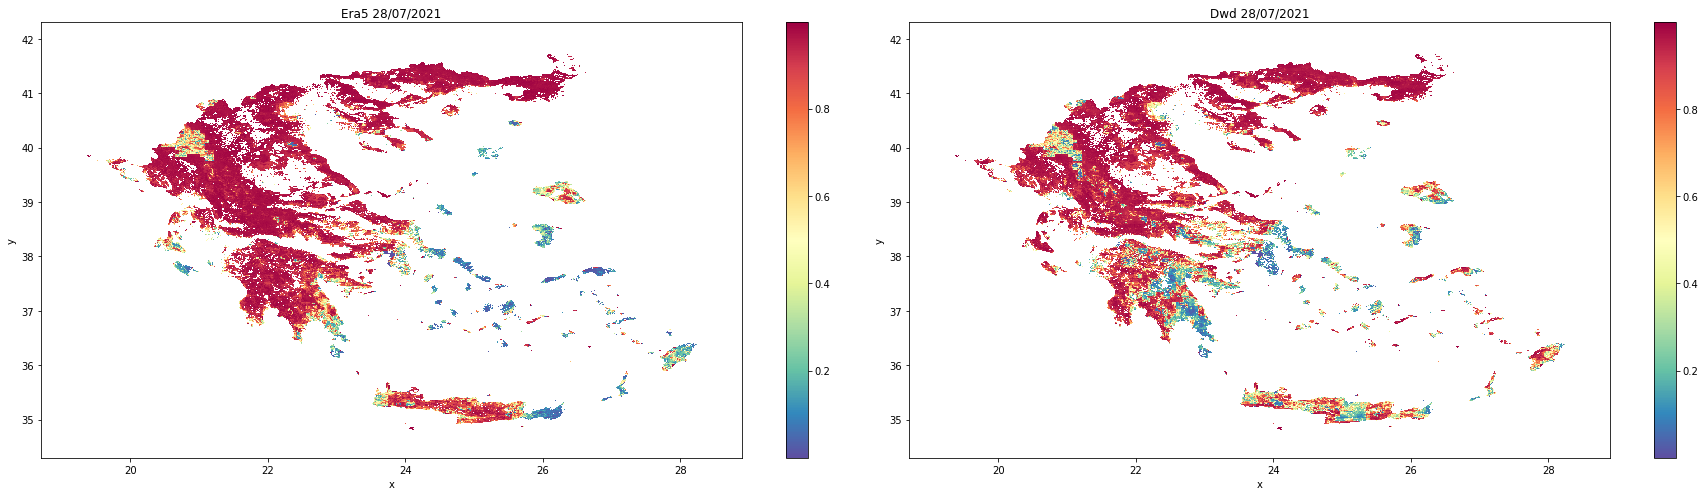

In [38]:
ds_era5 = xr.open_dataset(Path.home() / 'hdd1/diogenis/observatory/Plots/era5_2021_07_28.tif')
ds_era5 = ds_era5.to_array()
ds_dwd = xr.open_dataset(Path.home() / 'hdd1/diogenis/observatory/Plots/dwd_2021_07_28.tif')
ds_dwd = ds_dwd.to_array()

fig, axes = plt.subplots(ncols=2, figsize = (25,7))

ds_era5.plot(cmap = "Spectral_r", ax = axes[0])
axes[0].set_title('Era5 28/07/2021')

ds_dwd.plot(cmap = "Spectral_r", ax = axes[1])
axes[1].set_title('Dwd 28/07/2021')

plt.tight_layout()

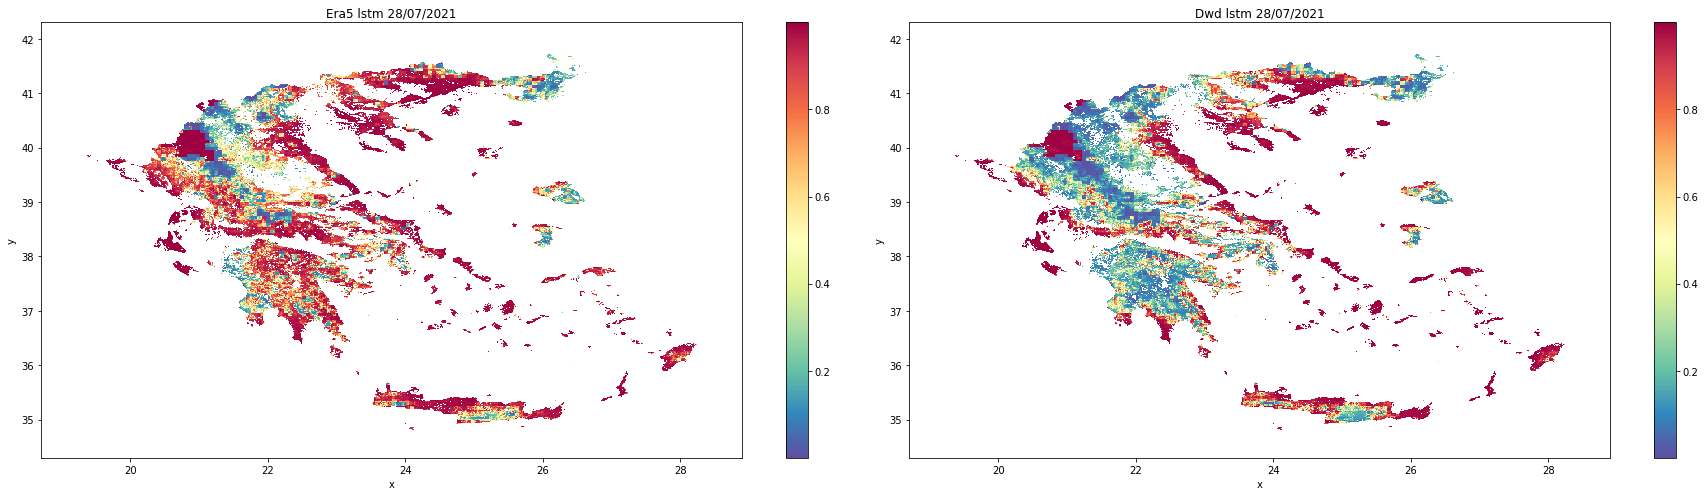

In [39]:
ds_era5 = xr.open_dataset(Path.home() / 'hdd1/diogenis/observatory/Plots/era5_2021_07_28_lstm.tif')
ds_era5 = ds_era5.to_array()
ds_dwd = xr.open_dataset(Path.home() / 'hdd1/diogenis/observatory/Plots/dwd_2021_07_28_lstm.tif')
ds_dwd = ds_dwd.to_array()

fig, axes = plt.subplots(ncols=2, figsize = (25,7))

ds_era5.plot(cmap = "Spectral_r", ax = axes[0])
axes[0].set_title('Era5 lstm 28/07/2021')

ds_dwd.plot(cmap = "Spectral_r", ax = axes[1])
axes[1].set_title('Dwd lstm 28/07/2021')

plt.tight_layout()

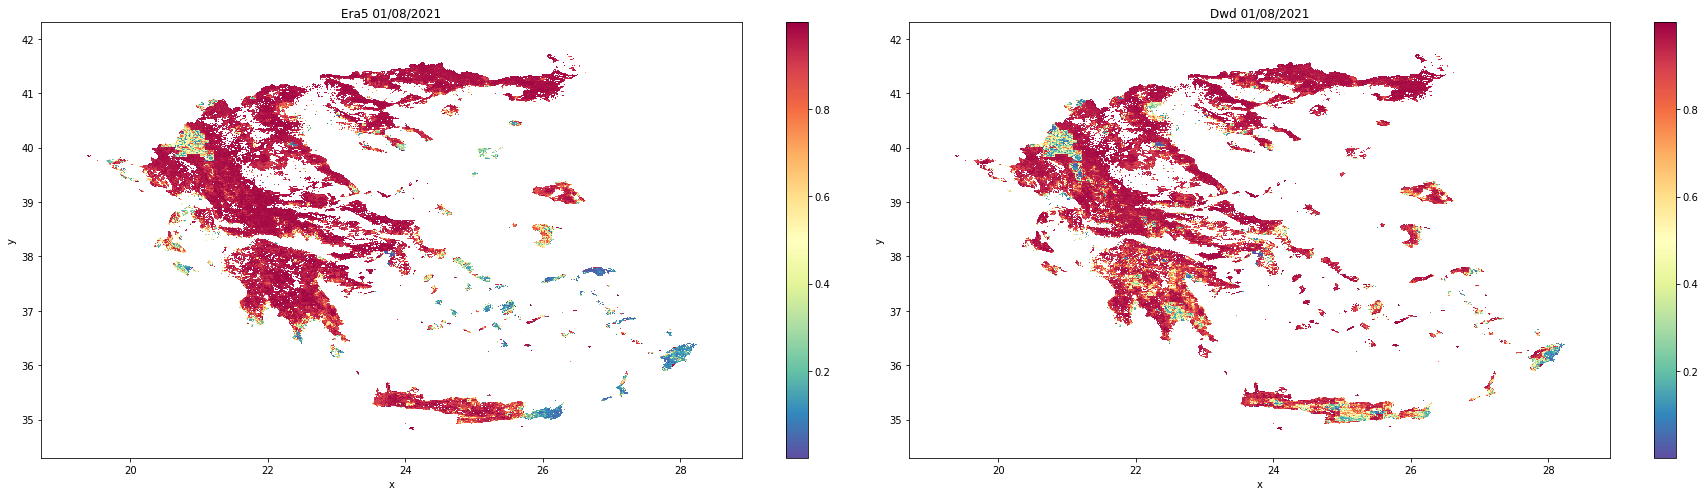

In [40]:
ds_era5 = xr.open_dataset(Path.home() / 'hdd1/diogenis/observatory/Plots/era5_2021_08_01.tif')
ds_era5 = ds_era5.to_array()
ds_dwd = xr.open_dataset(Path.home() / 'hdd1/diogenis/observatory/Plots/dwd_2021_08_01.tif')
ds_dwd = ds_dwd.to_array()

fig, axes = plt.subplots(ncols=2, figsize = (25,7))

ds_era5.plot(cmap = "Spectral_r", ax = axes[0])
axes[0].set_title('Era5 01/08/2021')

ds_dwd.plot(cmap = "Spectral_r", ax = axes[1])
axes[1].set_title('Dwd 01/08/2021')

plt.tight_layout()

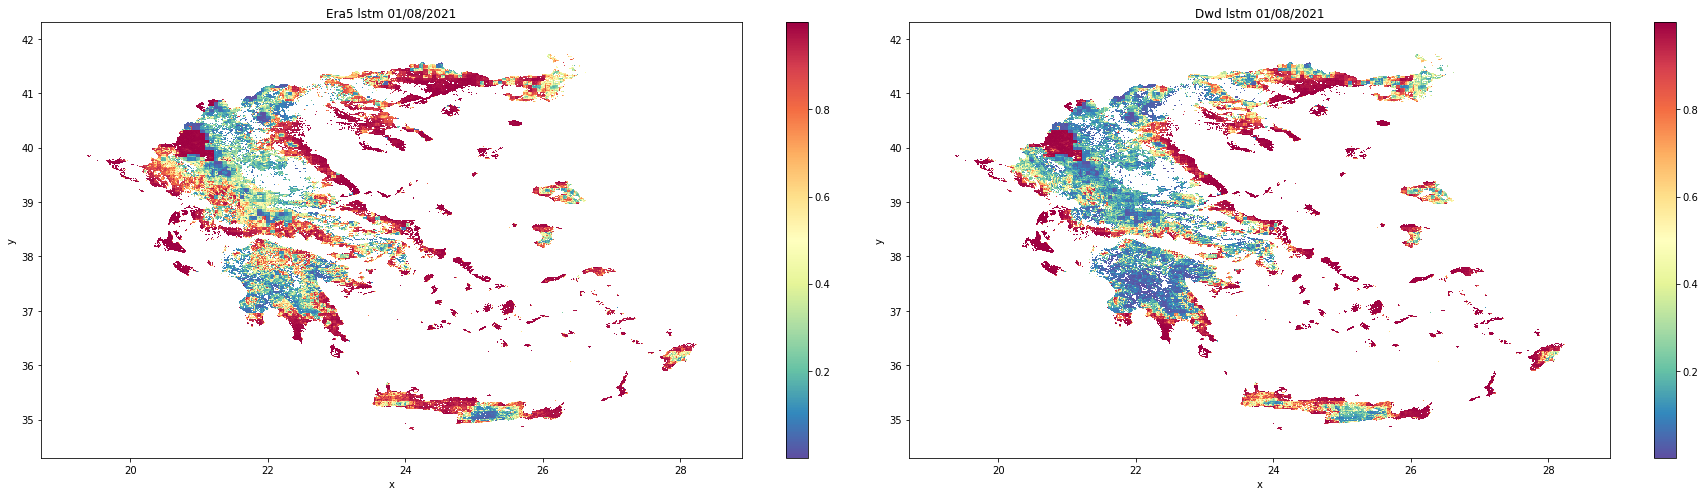

In [41]:
ds_era5 = xr.open_dataset(Path.home() / 'hdd1/diogenis/observatory/Plots/era5_2021_08_01_lstm.tif')
ds_era5 = ds_era5.to_array()
ds_dwd = xr.open_dataset(Path.home() / 'hdd1/diogenis/observatory/Plots/dwd_2021_08_01_lstm.tif')
ds_dwd = ds_dwd.to_array()

fig, axes = plt.subplots(ncols=2, figsize = (25,7))

ds_era5.plot(cmap = "Spectral_r", ax = axes[0])
axes[0].set_title('Era5 lstm 01/08/2021')

ds_dwd.plot(cmap = "Spectral_r", ax = axes[1])
axes[1].set_title('Dwd lstm 01/08/2021')

plt.tight_layout()

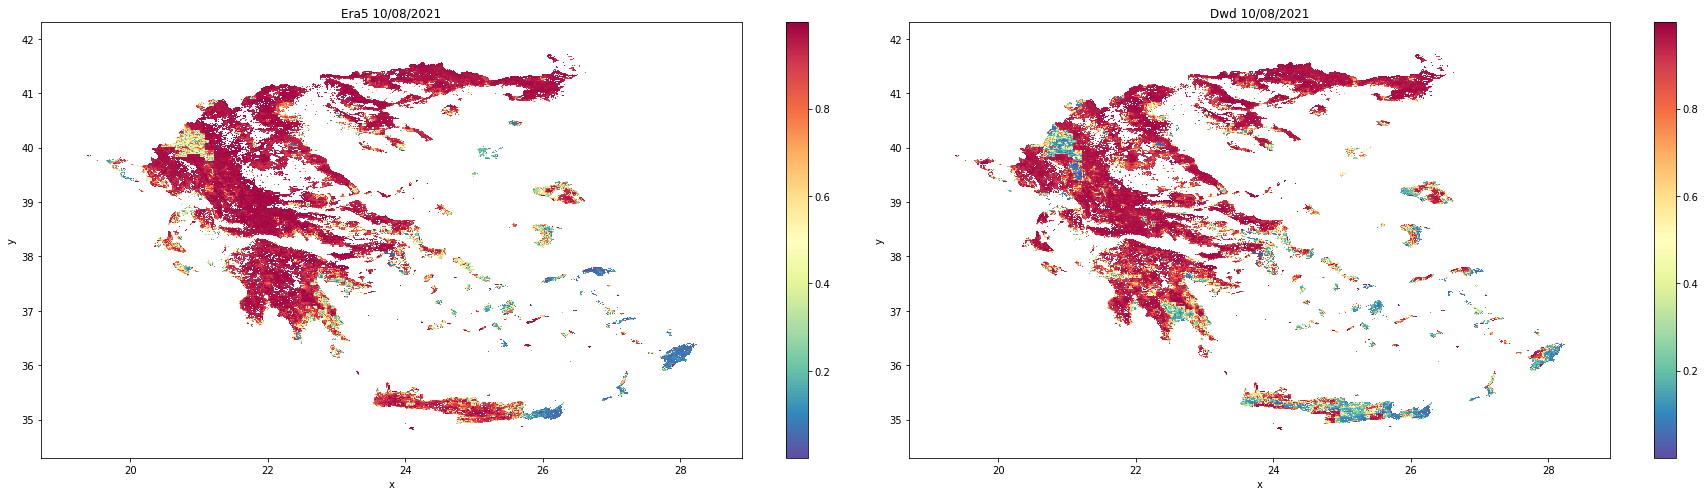

In [42]:
ds_era5 = xr.open_dataset(Path.home() / 'hdd1/diogenis/observatory/Plots/era5_2021_08_10.tif')
ds_era5 = ds_era5.to_array()
ds_dwd = xr.open_dataset(Path.home() / 'hdd1/diogenis/observatory/Plots/dwd_2021_08_10.tif')
ds_dwd = ds_dwd.to_array()

fig, axes = plt.subplots(ncols=2, figsize = (25,7))

ds_era5.plot(cmap = "Spectral_r", ax = axes[0])
axes[0].set_title('Era5 10/08/2021')

ds_dwd.plot(cmap = "Spectral_r", ax = axes[1])
axes[1].set_title('Dwd 10/08/2021')

plt.tight_layout()

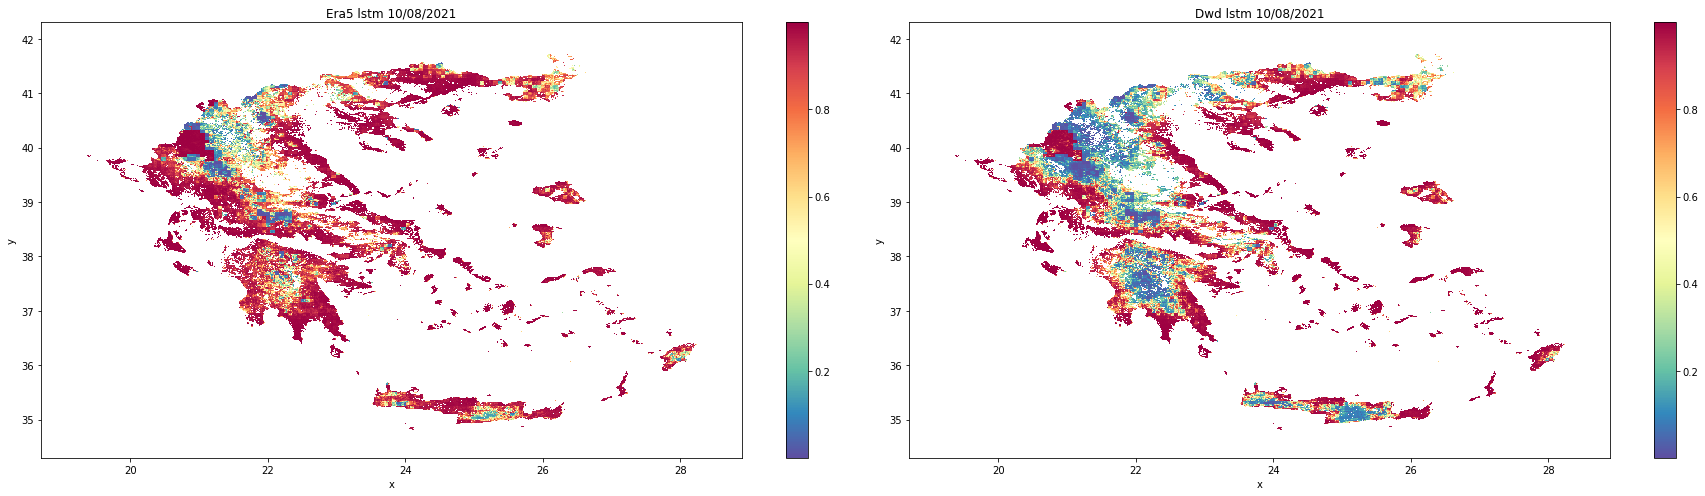

In [43]:
ds_era5 = xr.open_dataset(Path.home() / 'hdd1/diogenis/observatory/Plots/era5_2021_08_10_lstm.tif')
ds_era5 = ds_era5.to_array()
ds_dwd = xr.open_dataset(Path.home() / 'hdd1/diogenis/observatory/Plots/dwd_2021_08_10_lstm.tif')
ds_dwd = ds_dwd.to_array()

fig, axes = plt.subplots(ncols=2, figsize = (25,7))

ds_era5.plot(cmap = "Spectral_r", ax = axes[0])
axes[0].set_title('Era5 lstm 10/08/2021')

ds_dwd.plot(cmap = "Spectral_r", ax = axes[1])
axes[1].set_title('Dwd lstm 10/08/2021')

plt.tight_layout()

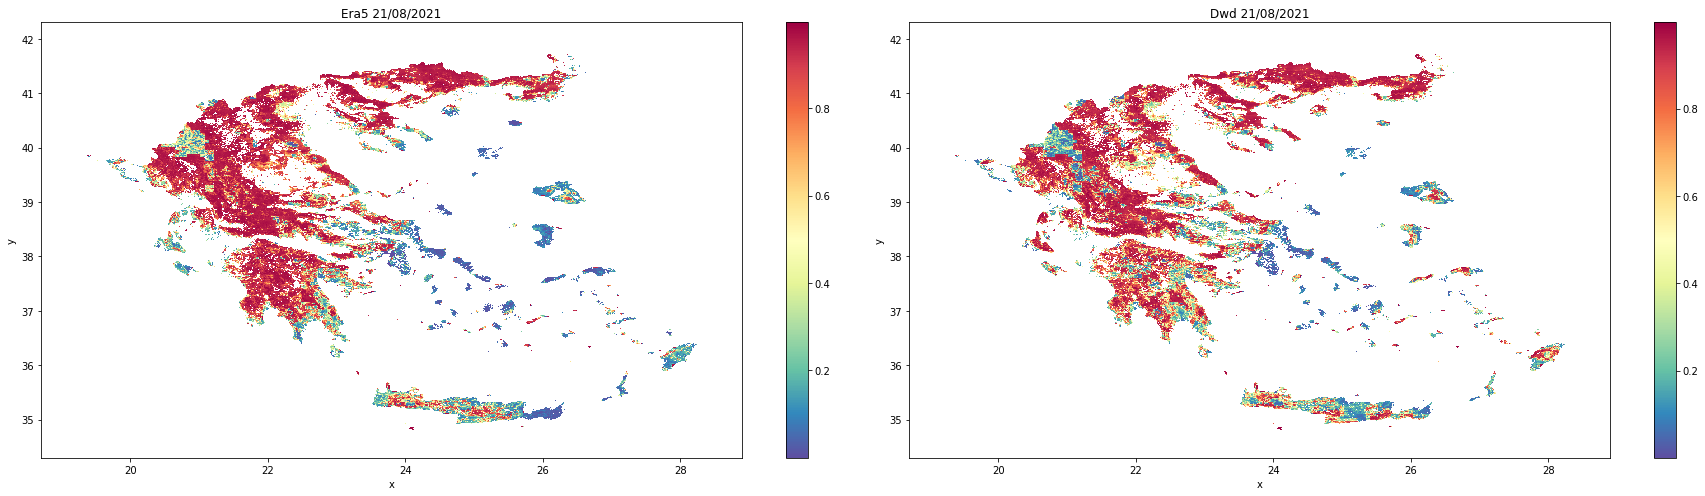

In [44]:
ds_era5 = xr.open_dataset(Path.home() / 'hdd1/diogenis/observatory/Plots/era5_2021_08_21.tif')
ds_era5 = ds_era5.to_array()
ds_dwd = xr.open_dataset(Path.home() / 'hdd1/diogenis/observatory/Plots/dwd_2021_08_21.tif')
ds_dwd = ds_dwd.to_array()

fig, axes = plt.subplots(ncols=2, figsize = (25,7))

ds_era5.plot(cmap = "Spectral_r", ax = axes[0])
axes[0].set_title('Era5 21/08/2021')

ds_dwd.plot(cmap = "Spectral_r", ax = axes[1])
axes[1].set_title('Dwd 21/08/2021')

plt.tight_layout()

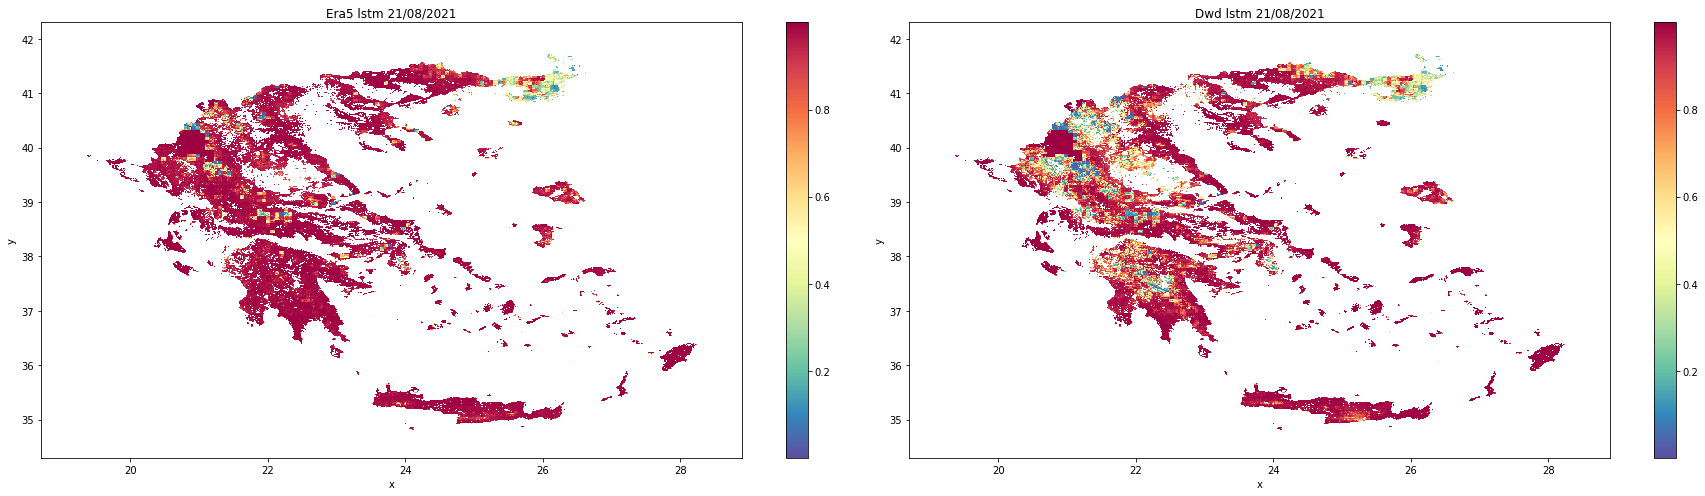

In [45]:
ds_era5 = xr.open_dataset(Path.home() / 'hdd1/diogenis/observatory/Plots/era5_2021_08_21_lstm.tif')
ds_era5 = ds_era5.to_array()
ds_dwd = xr.open_dataset(Path.home() / 'hdd1/diogenis/observatory/Plots/dwd_2021_08_21_lstm.tif')
ds_dwd = ds_dwd.to_array()

fig, axes = plt.subplots(ncols=2, figsize = (25,7))

ds_era5.plot(cmap = "Spectral_r", ax = axes[0])
axes[0].set_title('Era5 lstm 21/08/2021')

ds_dwd.plot(cmap = "Spectral_r", ax = axes[1])
axes[1].set_title('Dwd lstm 21/08/2021')

plt.tight_layout()